In [1]:
from time import time, sleep
import numpy as np
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
from IPython import display

In [2]:
%run homework_modules.ipynb
%matplotlib inline

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

In [4]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [5]:
# download datasets
features_train, target_train = loadlocal_mnist(
        images_path='dataset/train-images.idx3-ubyte', 
        labels_path='dataset/train-labels.idx1-ubyte')
features_test, target_test = loadlocal_mnist(
        images_path='dataset/t10k-images.idx3-ubyte',
        labels_path='dataset/t10k-labels.idx1-ubyte')

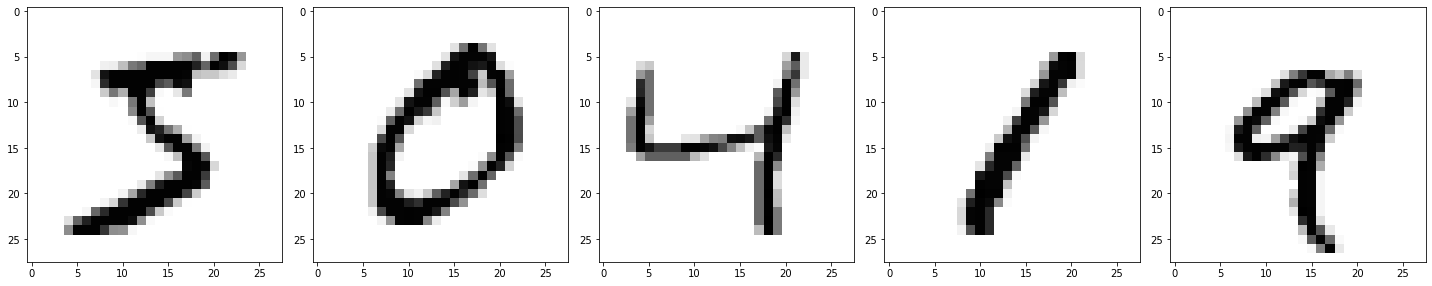

In [6]:
# view some data
fig, axes = plt.subplots(1, 5, figsize=(20,15))
axes = axes.flatten()
for img, ax in zip(features_train[:5].reshape((-1,28,28)), axes):
    ax.imshow(img, cmap="Greys")
plt.tight_layout()
plt.show()

In [7]:
target_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [8]:
# normalize features
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
x_train = X_scale.fit_transform(features_train)
x_test = X_scale.fit_transform(features_test)

In [9]:
# target one-hot-coding
y_train = np.zeros((target_train.shape[0], target_train.max() + 1), dtype=float)
y_test = np.zeros((target_test.shape[0], target_test.max() + 1), dtype=float)
for i in range(target_train.shape[0]):
    y_train[i][target_train[i]] = 1.0
for i in range(target_test.shape[0]):
    y_test[i][target_test[i]] = 1.0

In [10]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 200

In [11]:
# build neural network
neural_net = Sequential()
neural_net.add(Linear(x_train.shape[1], 500))
neural_net.add(Sigmoid())
neural_net.add(Linear(500, 50))
neural_net.add(Sigmoid())
neural_net.add(Linear(50, 10))
neural_net.add(SoftMax())

criterion = MSECriterion()

print(neural_net)

Linear 784 -> 500
Sigmoid
Linear 500 -> 50
Sigmoid
Linear 50 -> 10
SoftMax



In [12]:
train_loss_history = []
test_loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train), batch_size):
        
        neural_net.zeroGradParameters()
        
        # Forward
        predictions = neural_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        neural_net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(neural_net.getParameters(), 
                     neural_net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss_history.append(loss)
    
    # Test
    test_pred = neural_net.forward(x_test)
    test_loss = criterion.forward(test_pred, y_test)
    test_loss_history.append(test_loss)
    
    # accuracy
    hits = 0
    for prediction, label in zip(test_pred, target_test):
        if np.argmax(prediction) == label:
            hits += 1
    test_accuracy = hits / len(target_test) * 100

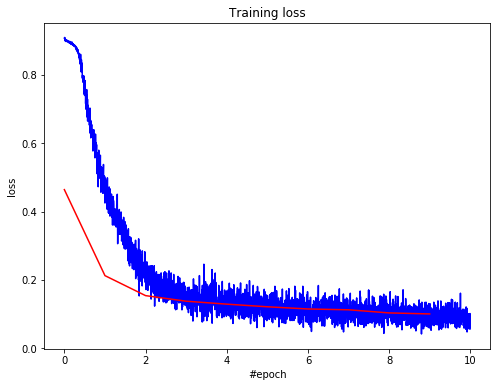

Current train loss: 0.056599
Current test loss: 0.100345
Current test accuracy: 93.460000


In [13]:

# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
epoch_ticks = np.arange(0, len(train_loss_history), dtype=float) / (y_train.shape[0] // batch_size)
plt.plot(epoch_ticks, train_loss_history, 'b')
plt.plot(test_loss_history, 'r')

plt.show()

print('Current train loss: %f' % loss)
print('Current test loss: %f' % test_loss)
print('Current test accuracy: %f' % test_accuracy)

In [14]:
neural_net_1 = Sequential()
neural_net_1.add(Linear(x_train.shape[1], 500))
neural_net_1.add(Sigmoid())
neural_net_1.add(Dropout(0.8))
neural_net_1.add(Linear(500, 50))
neural_net_1.add(Sigmoid())
neural_net_1.add(Dropout(0.8))
neural_net_1.add(Linear(50, 10))
neural_net_1.add(SoftMax())

criterion = MSECriterion()

print(neural_net_1)

Linear 784 -> 500
Sigmoid
Dropout
Linear 500 -> 50
Sigmoid
Dropout
Linear 50 -> 10
SoftMax



In [15]:
train_loss_history = []
test_loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train), batch_size):
        
        neural_net_1.zeroGradParameters()
        
        # Forward
        predictions = neural_net_1.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        neural_net_1.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(neural_net_1.getParameters(), 
                     neural_net_1.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss_history.append(loss)
    
    # Test
    test_pred = neural_net_1.forward(x_test)
    test_loss = criterion.forward(test_pred, y_test)
    test_loss_history.append(test_loss)
    
    # accuracy
    hits = 0
    for prediction, label in zip(test_pred, target_test):
        if np.argmax(prediction) == label:
            hits += 1
    test_accuracy = hits / len(target_test) * 100


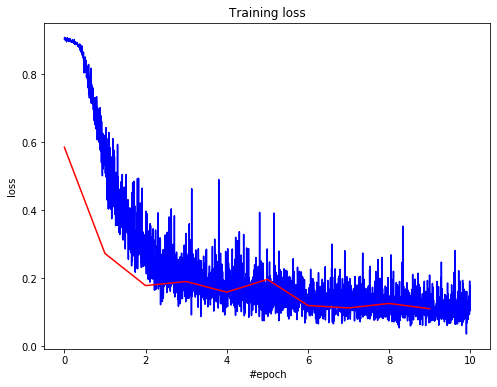

Current train loss: 0.176443
Current test loss: 0.109618
Current test accuracy: 92.920000


In [16]:

# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
epoch_ticks = np.arange(0, len(train_loss_history), dtype=float) / (y_train.shape[0] // batch_size)
plt.plot(epoch_ticks, train_loss_history, 'b')
plt.plot(test_loss_history, 'r')

plt.show()

print('Current train loss: %f' % loss)
print('Current test loss: %f' % test_loss)
print('Current test accuracy: %f' % test_accuracy)

In [17]:
np.argmax(test_pred[0])

7

In [18]:
target_test[0]

7